# Environment

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# from IPython.core.display_functions import display
from PIL import Image, ImageOps
from torchvision.transforms import Compose, Resize, ToTensor
# import cv2 as cv
from collections import deque

import torch.optim as optim
import torch
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
import os
# from einops import rearrange, reduce, repeat
# from einops.layers.torch import Rearrange, Reduce
# from torchsummary import summary
# from torch.distributions import Categorical

In [3]:
# ! pip install torchvision

In [39]:
def generate_cropped_im(im, cropped_dims):
    h_shift = 10
    s_shift = 10
    v_shift = 50
    # generate random crop shifts
    crop_attributes = {}
#     cropped_shift = [np.random.randint(0,im.size[0]-cropped_dims[0]),np.random.randint(0,im.size[1]-cropped_dims[1])]
    cropped_shift = [37,37]
    crop_coords = (cropped_shift[0], cropped_shift[1], cropped_shift[0]+cropped_dims[0], cropped_shift[1]+cropped_dims[1])
    cropped_im = im.crop(crop_coords)
    cropped_im = cropped_im.convert('HSV')
    h, s, v = cropped_im.split()
    h = h.point(lambda p: p + h_shift)
    s = s.point(lambda p: p + s_shift)
    v = v.point(lambda p: p + v_shift)
    cropped_im = Image.merge('HSV', (h, s, v))
    cropped_im = cropped_im.convert('RGB')
    cropped_im_shape = cropped_im.size
    crop_attributes['crop_coords'] = crop_coords
    crop_attributes['cropped_shift'] = cropped_shift
    crop_attributes['cropped_im'] = cropped_im
    crop_attributes['cropped_im_shape'] = cropped_im_shape
    
    return crop_attributes

In [40]:
class Env:
    def __init__(self, fixed_image, moving_image, crop_coords=(37, 37, 74, 74)):
        self.crop_coords = crop_coords
        self.fixed_image = fixed_image
        self.moving_image = moving_image
        self.fixed_x = fixed_image.size[0]
        self.fixed_y = fixed_image.size[1]
        self.crop_x = crop_coords[0]
        self.crop_y = crop_coords[1]
        self.shift_x = 0
        self.shift_y = 0
        self.x_limit = fixed_image.size[0] - moving_image.size[0]
        self.y_limit = fixed_image.size[1] - moving_image.size[1]
        self.env_image = fixed_image.copy()
        self.env_image.paste(moving_image, (0,0))
        self.action_space = 4

#     def reset(self):
#         # move image to a random position
#         print(self.x_limit)
#         self.shift_x = np.random.randint(0, self.x_limit)
#         self.shift_y = np.random.randint(0, self.y_limit)
#         self.env_image = self.fixed_image.copy()
#         self.env_image.paste(self.moving_image, (self.shift_x, self.shift_y))
#         return self.env_image
    
    def reset(self):
        crop_attr = generate_cropped_im(self.fixed_image, [37,37])
        self.crop_coords = crop_attr['crop_coords']
        print(f"Crop coords: {self.crop_coords}")
        self.moving_image = crop_attr['cropped_im']
        self.crop_x = self.crop_coords[0]
        self.crop_y = self.crop_coords[1]
        self.x_limit = self.fixed_image.size[0] - self.moving_image.size[0]
        self.y_limit = self.fixed_image.size[1] - self.moving_image.size[1]
        # move image to a random position
        print(self.x_limit)
        self.shift_x = np.random.randint(0, self.x_limit)
        self.shift_y = np.random.randint(0, self.y_limit)
        self.env_image = self.fixed_image.copy()
        self.env_image.paste(self.moving_image, (self.shift_x, self.shift_y))
        
        return self.env_image

    def check_frame(self, _im):
        _im_shape = _im.size
        _im_shape = [_im_shape[0] - 1, _im_shape[1] - 1]
        # check bottom border
        for i in range(_im_shape[0]):
            px = _im.getpixel((i, 0))
            if not (px[0] == 0 and px[1] == 0 and px[2] == 0):
                return False
        # check top border
        for i in range(_im_shape[0]):
            px = _im.getpixel((i, _im_shape[1]))
            if not (px[0] == 0 and px[1] == 0 and px[2] == 0):
                return False
        # check left border
        for i in range(_im_shape[1]):
            px = _im.getpixel((0, i))
            if not (px[0] == 0 and px[1] == 0 and px[2] == 0):
                return False
        # check right border
        for i in range(_im_shape[1]):
            px = _im.getpixel((_im_shape[0], i))
            if not (px[0] == 0 and px[1] == 0 and px[2] == 0):
                return False
        return True

    def move_image(self, _x, _y):
        shift_x = int(self.shift_x + _x)
        shift_y = int(self.shift_y + _y)
        # shift_x = _x
        # shift_y = _y
        # check if image can be moved
        if shift_x > self.x_limit:
            shift_x = self.x_limit
            # print('x limit reached')
        elif shift_x < 0:
            shift_x = 0
            # print('x limit reached')
        if shift_y > self.y_limit:
            shift_y = self.y_limit
            # print('y limit reached')
        elif shift_y < 0:
            shift_y = 0
            # print('y limit reached')
        if shift_x < 0 or shift_y < 0:
            print(f"Image can't be moved to {shift_x}, {shift_y}")
            return self.env_image, self.get_reward()
        self.shift_x = shift_x
        self.shift_y = shift_y
        env_copy = self.fixed_image.copy()
        env_copy.paste(self.moving_image, (shift_x, shift_y))
        self.env_image = env_copy
        reward = self.get_reward()
        # print(f"shift x {shift_x}, shift y {shift_y}, moved x {_x}, moved y {_y} moved x {self.crop_x}, moved y {self.crop_y}, reward {reward}")
        return env_copy, reward

    def get_reward(self):
        distance = np.sqrt((self.shift_x - self.crop_x)**2 + (self.shift_y - self.crop_y)**2)
        return -distance

    def get_target(self, shift_x, shift_y):
        _x = self.crop_x - shift_x
        _y = self.crop_y - shift_y
        target_x = 0.5+(_x/(2*self.x_limit))
        target_y = 0.5+(_y/(2*self.y_limit))
        return target_x, target_y

    def get_pred_target(self, pred):
        shift_x = (pred[0]*2-1) * self.x_limit
        shift_y = (pred[1]*2-1) * self.y_limit
        _x = self.crop_x - shift_x
        _y = self.crop_y - shift_y
        pred_target_x = 0.5+(_x/(2*self.x_limit))
        pred_target_y = 0.5+(_y/(2*self.y_limit))
        return pred_target_x, pred_target_y
        # return _x, _y

    def move_image_old(self, x, y):
        # move image using pil
        new_im = self.moving_image.transform(self.moving_image.size, Image.AFFINE, (1, 0, x, 0, 1, y))
        can_move = self.check_frame(new_im)
        if can_move:
            self.moving_image = new_im
            return new_im
        else:
            return self.moving_image

    def step(self, action, amount=1):
        """
        action: 0 = left, 1 = right, 2 = up, 3 = down
        """
        if action == 0:
            new_im, reward = self.move_image(amount, 0)
        elif action == 1:
            new_im, reward = self.move_image(0, amount)
        elif action == 2:
            new_im, reward = self.move_image(-amount, 0)
        elif action == 3:
            new_im, reward = self.move_image(0, -amount)
        else:
            raise ValueError(f"Action {action} is not valid")
        if reward >= -1:
            reward = 100
            return new_im, reward, True
        else:
            return new_im, reward, False

In [41]:
def preprocess_data(path, display=True):
    h_shift = 0
    s_shift = 0
    v_shift = 0
    envs = []
    for i, filename in enumerate(os.listdir(path)):
        if filename.endswith(".jpg"):
            if i == 100:
                break
            im = Image.open('/'.join([path, filename]))
            im_shape = im.size
            if im_shape[0] >= 112 and im_shape[1] >= 112:
                im_scale_x = im_shape[0]/112
                im_scale_y = im_shape[1]/112

                scale = 1/2
                im = im.resize((int(im_shape[0]/im_scale_x),int(im_shape[1]/im_scale_y)),Image.ANTIALIAS)
                im_shape = im.size
                im = im.crop((0, 0, 112, 112))
                im_shape = im.size
                cropped_dims = [37, 37]
                crop_attr = generate_cropped_im(im, cropped_dims)
                cropped_im = crop_attr['cropped_im']
                # change cropped image hue
                cropped_im = cropped_im.convert('HSV')
                cropped_im_shape = crop_attr['cropped_im_shape']
                print(f'im_shape: {im_shape}, cropped_im_shape: {cropped_im_shape}')
                crop_coords = crop_attr['crop_coords']

                # red_dot = Image.new('RGB', (10, 10), color = 'red')
                # green_dot = Image.new('RGB', (10, 10), color = 'green')
                env_im = im
                # cropped_im.paste(red_dot, (0,0))
                fixed_x = crop_coords[0]
                fixed_y = crop_coords[1]
                shift_x = im_shape[0] - cropped_im_shape[0]
                shift_y = 0

                fixed = (fixed_x, fixed_y)
                moving = (shift_x, shift_y)

                distance = np.sqrt((fixed[0] - moving[0])**2 + (fixed[1] - moving[1])**2)

                # env_im.paste(cropped_im, (shift_x, shift_y))
                # env_im.paste(green_dot, (fixed_x, fixed_y))
                env = Env(im, cropped_im, crop_coords)
                envs.append(env)
                print(f'image: {path},  distance: {distance}')
                im2 = im.copy()
                if display:
                    plt.imshow(im2)
                    plt.show()
                    plt.imshow(cropped_im)
                    plt.show()
                # resize to imagenet size
                transform = Compose([Resize((112, 112)), ToTensor()])
                x = transform(im)
                x = x.unsqueeze(0) # add batch dim
                x.shape
    return envs

In [42]:
# envs_test = preprocess_data('pets')

In [43]:
envs = preprocess_data('coffee', display=False)

im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 53.03772242470448
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 53.03772242470448
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 53.03772242470448
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 53.03772242470448
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 53.03772242470448
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 53.03772242470448
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 53.03772242470448
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 53.03772242470448
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 53.03772242470448
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 53.03772242470448
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  dista

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


In [44]:
device = torch.device("cuda")
print(device)

env = envs[1]

cuda


Crop coords: (37, 37, 74, 74)
75
Reward: -14.7648230602334


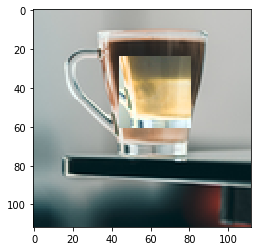

-7 13
-0.0


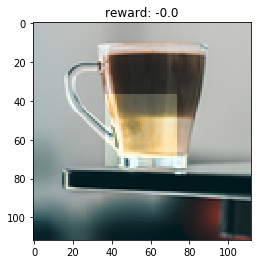

In [45]:
im_b = env.reset()
reward = env.get_reward()
print(f"Reward: {reward}")
plt.imshow(im_b)
plt.show()
# print(f"shift coords: {env.shift_x}, {env.shift_y}")
# print(f"moving coords: {env.crop_x}, {env.crop_y}")
# print(f"diff: {env.crop_x-env.shift_x}, {env.crop_y-env.shift_y}")
targets = env.get_pred_target([0.5+(env.shift_x/(2*env.x_limit)),0.5+(env.shift_y/(2*env.y_limit))])
print(env.crop_x-env.shift_x+0 ,env.crop_y - env.shift_y+0)
im_a, r = env.move_image(env.crop_x-env.shift_x ,env.crop_y - env.shift_y)
print(r)
plt.imshow(im_a)
plt.title(f'reward: {r}')
plt.show()

In [46]:
%matplotlib inline



Reinforcement Learning (DQN) Tutorial
=====================================
**Author**: `Adam Paszke <https://github.com/apaszke>`_


This tutorial shows how to use PyTorch to train a Deep Q Learning (DQN) agent
on the CartPole-v0 task from the `OpenAI Gym <https://www.gymlibrary.ml/>`__.

**Task**

The agent has to decide between two actions - moving the cart left or
right - so that the pole attached to it stays upright. You can find an
official leaderboard with various algorithms and visualizations at the
`Gym website <https://www.gymlibrary.ml/environments/classic_control/cart_pole>`__.

.. figure:: /_static/img/cartpole.gif
   :alt: cartpole

   cartpole

As the agent observes the current state of the environment and chooses
an action, the environment *transitions* to a new state, and also
returns a reward that indicates the consequences of the action. In this
task, rewards are +1 for every incremental timestep and the environment
terminates if the pole falls over too far or the cart moves more then 2.4
units away from center. This means better performing scenarios will run
for longer duration, accumulating larger return.

The CartPole task is designed so that the inputs to the agent are 4 real
values representing the environment state (position, velocity, etc.).
However, neural networks can solve the task purely by looking at the
scene, so we'll use a patch of the screen centered on the cart as an
input. Because of this, our results aren't directly comparable to the
ones from the official leaderboard - our task is much harder.
Unfortunately this does slow down the training, because we have to
render all the frames.

Strictly speaking, we will present the state as the difference between
the current screen patch and the previous one. This will allow the agent
to take the velocity of the pole into account from one image.

**Packages**


First, let's import needed packages. Firstly, we need
`gym <https://github.com/openai/gym>`__ for the environment
(Install using `pip install gym`).
We'll also use the following from PyTorch:

-  neural networks (``torch.nn``)
-  optimization (``torch.optim``)
-  automatic differentiation (``torch.autograd``)
-  utilities for vision tasks (``torchvision`` - `a separate
   package <https://github.com/pytorch/vision>`__).


In [47]:
# import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Replay Memory
-------------

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classses:

-  ``Transition`` - a named tuple representing a single transition in
   our environment. It essentially maps (state, action) pairs
   to their (next_state, reward) result, with the state being the
   screen difference image as described later on.
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.




In [48]:
import numpy as np

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):       
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Now, let's define our model. But first, let's quickly recap what a DQN is.

DQN algorithm
-------------

Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. It makes rewards from the uncertain far
future less important for our agent than the ones in the near future
that it can be fairly confident about.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

However, we don't know everything about the world, so we don't have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the `Huber
loss <https://en.wikipedia.org/wiki/Huber_loss>`__. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}

Q-network
^^^^^^^^^

Our model will be a convolutional neural network that takes in the
difference between the current and previous screen patches. It has two
outputs, representing $Q(s, \mathrm{left})$ and
$Q(s, \mathrm{right})$ (where $s$ is the input to the
network). In effect, the network is trying to predict the *expected return* of
taking each action given the current input.




In [49]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn4 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(conv2d_size_out(w))))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(conv2d_size_out(h))))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        return self.head(x.view(x.size(0), -1))

Input extraction
^^^^^^^^^^^^^^^^

The code below are utilities for extracting and processing rendered
images from the environment. It uses the ``torchvision`` package, which
makes it easy to compose image transforms. Once you run the cell it will
display an example patch that it extracted.




Crop coords: (37, 37, 74, 74)
75


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


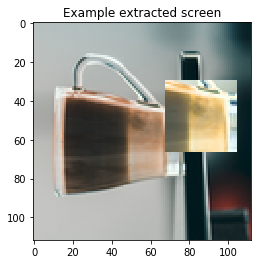

torch.Size([1, 3, 112, 112])


In [50]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(112, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen_old():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)

def get_screen():
    screen = env.env_image
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)

    return resize(screen.T).unsqueeze(0)




env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

print(get_screen().shape)

Training
--------

Hyperparameters and utilities
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
This cell instantiates our model and its optimizer, and defines some
utilities:

-  ``select_action`` - will select an action accordingly to an epsilon
   greedy policy. Simply put, we'll sometimes use our model for choosing
   the action, and sometimes we'll just sample one uniformly. The
   probability of choosing a random action will start at ``EPS_START``
   and will decay exponentially towards ``EPS_END``. ``EPS_DECAY``
   controls the rate of the decay.
-  ``plot_durations`` - a helper for plotting the durations of episodes,
   along with an average over the last 100 episodes (the measure used in
   the official evaluations). The plot will be underneath the cell
   containing the main training loop, and will update after every
   episode.




In [52]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 100
TARGET_UPDATE = 2
MEMORY_CAPACITY = 10000

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(MEMORY_CAPACITY)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            out = policy_net(state)
            act = out.max(1)[1].view(1, 1)
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

#     plt.pause(0.001)  # pause a bit so that plots are updated
#     if is_ipython:
# #         display.clear_output(wait=True)
# #         display.display(plt.gcf())

Training loop
^^^^^^^^^^^^^

Finally, the code for training our model.

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By definition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability. The target network has its weights kept frozen most of
the time, but is updated with the policy network's weights every so often.
This is usually a set number of steps but we shall use episodes for
simplicity.




In [53]:
def optimize_model(log_loss=False):
    if len(memory) < BATCH_SIZE:
        return
    # sample random (state, action, next_state, reward)*BATCH_SIZE from the memory and get the values for their values.
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    # find for each next state whether it's none or not
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    if log_loss:
        print(f"Loss: {loss}")
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

Crop coords: (37, 37, 74, 74)
75


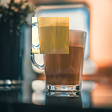

In [54]:
env = envs[3]
env.reset()

Below, you can find the main training loop. At the beginning we reset
the environment and initialize the ``state`` Tensor. Then, we sample
an action, execute it, observe the next screen and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

Below, `num_episodes` is set small. You should download
the notebook and run lot more epsiodes, such as 300+ for meaningful
duration improvements.




Crop coords: (37, 37, 74, 74)
75


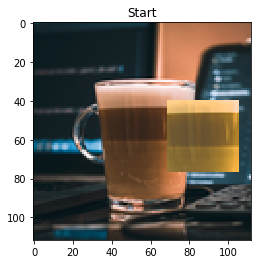

0# episode: 0, reward: None, action: tensor([[3]], device='cuda:0')
50# episode: 0, reward: -37.16180835212409, action: tensor([[1]], device='cuda:0')
100# episode: 0, reward: -38.01315561749642, action: tensor([[1]], device='cuda:0')
150# episode: 0, reward: -38.897300677553446, action: tensor([[3]], device='cuda:0')
Loss: 1.9692318430770923
200# episode: 0, reward: -8.06225774829855, action: tensor([[3]], device='cuda:0')
Loss: 1.1549146920071953
250# episode: 0, reward: -33.54101966249684, action: tensor([[3]], device='cuda:0')
Loss: 1.7974505012736057
300# episode: 0, reward: -37.656340767525464, action: tensor([[1]], device='cuda:0')
Loss: 1.520623067332172
350# episode: 0, reward: -34.20526275297414, action: tensor([[1]], device='cuda:0')
Loss: 1.6585453522369407
400# episode: 0, reward: -11.40175425099138, action: tensor([[3]], device='cuda:0')
Loss: 0.6118958314424954
450# episode: 0, reward: -10.0, action: tensor([[3]], device='cuda:0')
Loss: 1.0477817990773528
500# episode: 0

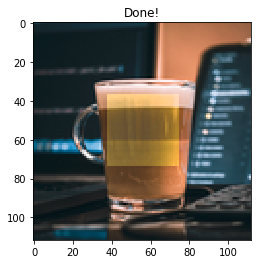

1046################ episode: 0, Done!!!!!!!
########### target updated.
Checkpoint saved.
Crop coords: (37, 37, 74, 74)
75


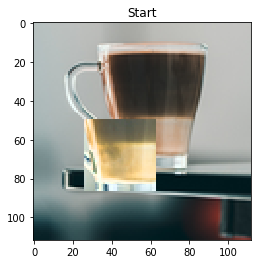

0# episode: 1, reward: None, action: tensor([[2]], device='cuda:0')
Loss: 22.0647252279799
50# episode: 1, reward: -13.038404810405298, action: tensor([[1]], device='cuda:0')
Loss: 1.7681686476590628
100# episode: 1, reward: -10.198039027185569, action: tensor([[1]], device='cuda:0')
Loss: 2.0700827324956377
150# episode: 1, reward: -10.198039027185569, action: tensor([[3]], device='cuda:0')
Loss: 0.8698800784529956
200# episode: 1, reward: -9.486832980505138, action: tensor([[3]], device='cuda:0')
Loss: 0.8677017128465151
250# episode: 1, reward: -8.246211251235321, action: tensor([[3]], device='cuda:0')
Loss: 0.6227416236903535


In [ ]:
#### import math

num_episodes = 140
for i_episode in range(num_episodes):
    plt.plot(episode_durations)
    plt.title("episode durations")
    plt.savefig("runtime_episodes.png")
    env = envs[i_episode%12]
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    movement_power = 1
    last_reward = None
    plt.imshow(env.env_image)
    plt.title('Start')
    plt.show()
    episode_rewards = []
    for t in count():
        if t > 10000:
            episode_durations.append(t + 1)
            print(f"Episode #{i_episode} reached the maximum steps")
            break
        # Select and perform an action
        action = select_action(state)
        if last_reward is not None:
            if last_reward > -10:
                movement_power = 1
            else:
                movement_power = math.ceil(abs(last_reward)/2)
                if movement_power < 1:
                    movement_power = 1
        state_im, reward, done = env.step(action.item(),1)
        log_loss = False
        if t%50 == 0:
            print(f"{t}# episode: {i_episode}, reward: {last_reward}, action: {action}")
            log_loss = True    
#             plt.imshow(env.env_image)
#             plt.title(f"reward: {reward}")
#             plt.show()
        last_reward = reward
        
        episode_rewards.append(reward)
        
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model(log_loss)
        if done:
            plt.imshow(env.env_image)
            plt.title(f"Done!")
            plt.show()
            print(f"{t}################ episode: {i_episode}, Done!!!!!!!")
            episode_durations.append(t + 1)
            # plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        print(f"########### target updated.")
        target_net.load_state_dict(policy_net.state_dict())
        
    torch.save({
        'epoch': i_episode,
        'model_state_dict': target_net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, "checkpoints/target_ckpt.pt")
    torch.save({
        'epoch': i_episode,
        'model_state_dict': policy_net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, "checkpoints/policy_ckpt.pt")
    print(f"Checkpoint saved.")

print('Complete')

# env.render()
# env.close()
# plt.ioff()
# plt.show()

Here is the diagram that illustrates the overall resulting data flow.

.. figure:: /_static/img/reinforcement_learning_diagram.jpg

Actions are chosen either randomly or based on a policy, getting the next
step sample from the gym environment. We record the results in the
replay memory and also run optimization step on every iteration.
Optimization picks a random batch from the replay memory to do training of the
new policy. "Older" target_net is also used in optimization to compute the
expected Q values; it is updated occasionally to keep it current.




In [ ]:
plt.ioff()
plt.show()

In [ ]:

plt.plot(episode_durations)
plt.title("episode durations")
plt.show()
plt.savefig("50 episodes.png")

In [ ]:
episode_durations


In [ ]:
env = envs[4]
# Initialize the environment and state
env.reset()
last_screen = get_screen()
current_screen = get_screen()
state = current_screen - last_screen
last_reward = None
plt.imshow(env.env_image)
plt.title('Start')
plt.show()

for t in count():
    # Select and perform an action
    action = select_action(state)
    state_im, reward, done = env.step(action.item(),1)

    if t%5 == 0:
        print(f"{t}, reward: {reward}, action: {action}")
        plt.imshow(env.env_image)
        plt.title(f"reward: {reward}")
        plt.show()
    last_reward = reward


#     reward = torch.tensor([reward], device=device)

#     # Observe new state
    last_screen = current_screen
    current_screen = get_screen()
    if not done:
        next_state = current_screen - last_screen
    else:
        next_state = None

    # Store the transition in memory
#     memory.push(state, action, next_state, reward)

    # Move to the next state
    state = next_state

    # Perform one step of the optimization (on the policy network)
#     optimize_model()
    if done:
        plt.imshow(env.env_image)
        plt.title(f"Done!")
        plt.show()
        print(f"{t}################ step: {t}, Done!!!!!!!")
        episode_durations.append(t + 1)
        # plot_durations()
        break